<a href="https://colab.research.google.com/github/JavaOliverLu/python/blob/master/Semantic_Similarity_IPYNB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip3 install seaborn

In [2]:
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [3]:
#@title Compute a representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
logging.set_verbosity(logging.ERROR)

message_embeddings = embed(messages)

for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
  print("Message: {}".format(messages[i]))
  print("Embedding size: {}".format(len(message_embedding)))
  message_embedding_snippet = ", ".join(
      (str(x) for x in message_embedding[:3]))
  print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Message: Elephant
Embedding size: 512
Embedding: [0.008344486355781555, 0.00048085825983434916, 0.06595248728990555, ...]

Message: I am a sentence for which I would like to get its embedding.
Embedding size: 512
Embedding: [0.050808604806661606, -0.01652429811656475, 0.01573782227933407, ...]

Message: Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the embedding will be.
Embedding size: 512
Embedding: [-0.02833269163966179, -0.0558621808886528, -0.012941432185471058, ...]



In [4]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(messages_, message_embeddings_, 90)

Please input the setence FREE TO WIN


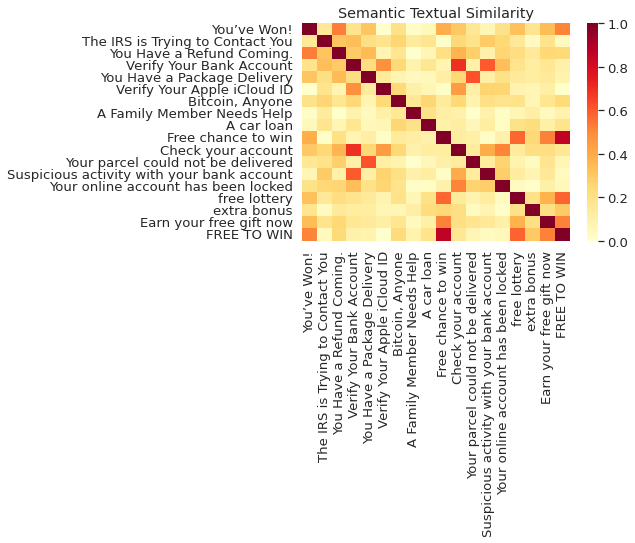

In [5]:
ejample=input("Please input the setence ")
messages = [
    "You’ve Won!",
    "The IRS is Trying to Contact You",
    "You Have a Refund Coming.",
    "Verify Your Bank Account",
    "You Have a Package Delivery",
    "Verify Your Apple iCloud ID",
    "Bitcoin, Anyone",
    "A Family Member Needs Help",
    "A car loan",
    "Free chance to win",
    "Check your account",
    "Your parcel could not be delivered",
    "Suspicious activity with your bank account",
    "Your online account has been locked",
    "free lottery",
    "extra bonus",
    "Earn your free gift now",
    ejample
]
run_and_plot(messages)

In [6]:
import pandas
import scipy
import math
import csv

sts_dataset = tf.keras.utils.get_file(
    fname="Stsbenchmark.tar.gz",
    origin="http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz",
    extract=True)
sts_dev = pandas.read_table(
    os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-dev.csv"),
    error_bad_lines=False,
    skip_blank_lines=True,
    usecols=[4, 5, 6],
    names=["sim", "sent_1", "sent_2"])
sts_test = pandas.read_table(
    os.path.join(
        os.path.dirname(sts_dataset), "stsbenchmark", "sts-test.csv"),
    error_bad_lines=False,
    quoting=csv.QUOTE_NONE,
    skip_blank_lines=True,
    usecols=[4, 5, 6],
    names=["sim", "sent_1", "sent_2"])
# cleanup some NaN values in sts_dev
sts_dev = sts_dev[[isinstance(s, str) for s in sts_dev['sent_2']]]

425984/409630 [===============================] - 1s 2us/step


In [7]:
class bcolors:
    OK = '\033[92m' #GREEN
    WARNING = '\033[93m' #YELLOW
    FAIL = '\033[91m' #RED
    RESET = '\033[0m' #RESET COLOR
    
sts_data = sts_dev #@param ["sts_dev", "sts_test"] {type:"raw"}

def run_sts_benchmark(batch):
  sts_encode1 = tf.nn.l2_normalize(embed(tf.constant(batch['sent_1'].tolist())), axis=1)
  sts_encode2 = tf.nn.l2_normalize(embed(tf.constant(batch['sent_2'].tolist())), axis=1)
  cosine_similarities = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
  clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
  scores = 1.0 - tf.acos(clip_cosine_similarities) / math.pi
  """Returns the similarity scores"""
  return scores

dev_scores = sts_data['sim'].tolist()
scores = []
for batch in np.array_split(sts_data, 10):
  scores.extend(run_sts_benchmark(batch))

pearson_correlation = scipy.stats.pearsonr(scores, dev_scores)
print('Pearson correlation coefficient = {0}'.format(pearson_correlation[0]))
kkk=pearson_correlation[0]
if(kkk>0.8036389336739346):
  print(f"{bcolors.FAIL}WARNING! It's a spam {bcolors.RESET}")
else:
  print(f"{bcolors.OK}SAFE!{bcolors.RESET}")

Pearson correlation coefficient = 0.8036398551227377
WARNING! It's a spam 
